In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Janin, Ramachandran
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

In [2]:
topo = '/mnt/c/Users/thier/Desktop/1ubq_frame.pdb'

full_traj1 = '/home/mlehner/1ubq/test_002/run_001/traj_4us_PBC_fit.xtc'


In [3]:
u = mda.Universe(topo, full_traj1)

In [4]:
r_ile = u.select_atoms("resname ILE")
J = Janin(r_ile).run()
print (J)

In [5]:
def count_rotamer_populations(chi1, chi2):
    results = np.zeros([3,3])
    for t, (c1, c2) in enumerate(zip(chi1, chi2)):
        c1 -= 180
        c2 -= 180
        i = None
        if -180 <= c1 <= -60: 
            i = 0
        elif -60 < c1 <= 60:
            i = 1
        else:
            i = 2
        
        j = None
        if -180 <= c2 <= -60: 
            j = 0
        elif -60 < c2 <= 60:
            j = 1
        else:
            j = 2
        
        #print (str(i) + '  ' + str(j) + ' ' + str(c1) + ', ' + str(c2))
        
        #if t > 4: break
        
        results[j][i] +=1
    return results/len(chi1)*100 # array of length 9
    
    

In [6]:
def plot_isoleucine_rotamer(chi1, chi2, ile, ff, color):
    
    fig, ax = plt.subplots(figsize = [7,7])
    
    # Draw some lines to separate rotamer populations
    for xv in [120, 240]:
        ax.axvline(x=xv, lw = 1, color = 'grey')
        ax.axhline(y=xv, lw = 1, color = 'grey')
  
    # Write the population numbers in the plot directly
    rot_pop = count_rotamer_populations(chi1, chi2)
    xlocs = np.array([-95, 25, 145]) + 180
    ylocs = np.array([-70, 50, 170]) + 180
    + 180
    for i, pop in enumerate(rot_pop):
        for j, sub_pop in enumerate(pop):
            ax.text(xlocs[j], ylocs[i], str(f'{sub_pop:.2f}') +'%')
        
    
    ax.scatter(chi1, chi2, marker = 'o', s = 2, color = color)
    #ax.hist2d(chi1-180, chi2-180, bins=(360, 360), cmap=plt.cm.Reds, alpha=0.5)#, marker = 'o', s = 2)
    
    ax.scatter(chi1[0], chi2[0], marker = '*', s = 72, color = 'black')
    
    ax.set_ylim([0, 360])
    ax.set_xlim([0, 360])
    
    ax.set_xticks(np.arange(0, 360+1, 60))
    ax.set_yticks(np.arange(0, 360+1, 60))
    
    ax.set_xlabel(r'$\chi_1$', fontsize = 14)
    ax.set_ylabel(r'$\chi_2$', fontsize = 14)
    
    plt.title( str(ile) + ' side chain rotamers - ' + ff, fontsize=14)
    fig.savefig("../../out_figures/dihedral_analysis/ile_" + str(ile) + ".png")
    #fig.savefig('tmp/' + ile.lower() + '_rotamers.png', facecolor='white')
    plt.close()
    
    return None
    

In [7]:
isoleucines = [3,13, 23, 30, 36, 44, 61]
x, y, z = np.shape((J.results.angles))
for i in range(y):
    chi1, chi2 = J.results.angles[:, i, :].T
    
    plot_isoleucine_rotamer(chi1, chi2, isoleucines[i], "", color = 'tab:blue')

In [8]:
x, y, z = np.shape((J.results.angles))
print(x,y,z)

400001 7 2


In [9]:
chi1 = pd.DataFrame(J.results.angles[:, :, 0], columns = isoleucines)
chi2 = pd.DataFrame(J.results.angles[:, :, 1], columns = isoleucines)

In [10]:
def bin_dihedral_angles(angle):
    bins = np.arange(0, 360, 120)
    bin_number = np.digitize(angle, bins)
    return (bin_number-1)*120+60

In [11]:
chi1_bin = chi1.applymap(bin_dihedral_angles)
chi2_bin = chi2.applymap(bin_dihedral_angles)

<AxesSubplot:>

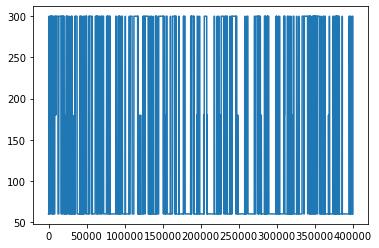

In [12]:
chi1_bin[isoleucines[1]].plot()

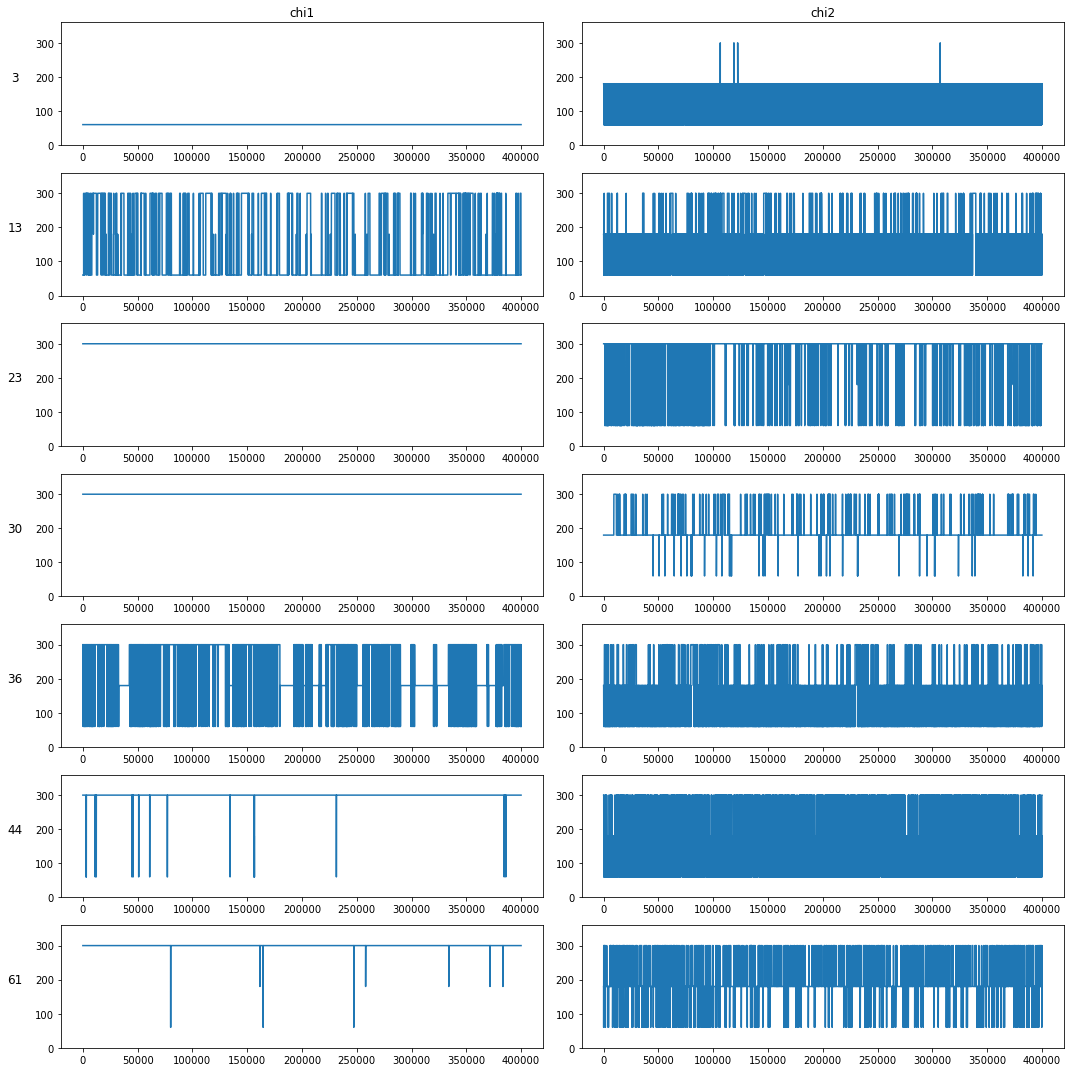

In [13]:
fig, axs = plt.subplots(len(isoleucines), 2, figsize = [15,15])
for i, ile in enumerate(isoleucines):
    axs[i,0].plot(chi1_bin[ile])
    axs[i,0].set_ylim([0, 360])
    axs[i,1].plot(chi2_bin[ile])
    axs[i,1].set_ylim([0, 360])
for ax, col in zip(axs[0], ["chi1", "chi2"]):
    ax.set_title(col)
for ax, row in zip(axs[:,0], isoleucines):
    ax.set_ylabel(row, rotation=0, size='large')
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20
fig.tight_layout()
plt.savefig("../../out_figures/dihedral_analysis/chi_binned.svg")
plt.savefig("../../out_figures/dihedral_analysis/chi_binned.pdf")
plt.show()

In [14]:
chi1_diff = chi1_bin.diff().applymap(lambda x: np.abs(x))
chi2_diff = chi2_bin.diff().applymap(lambda x: np.abs(x))

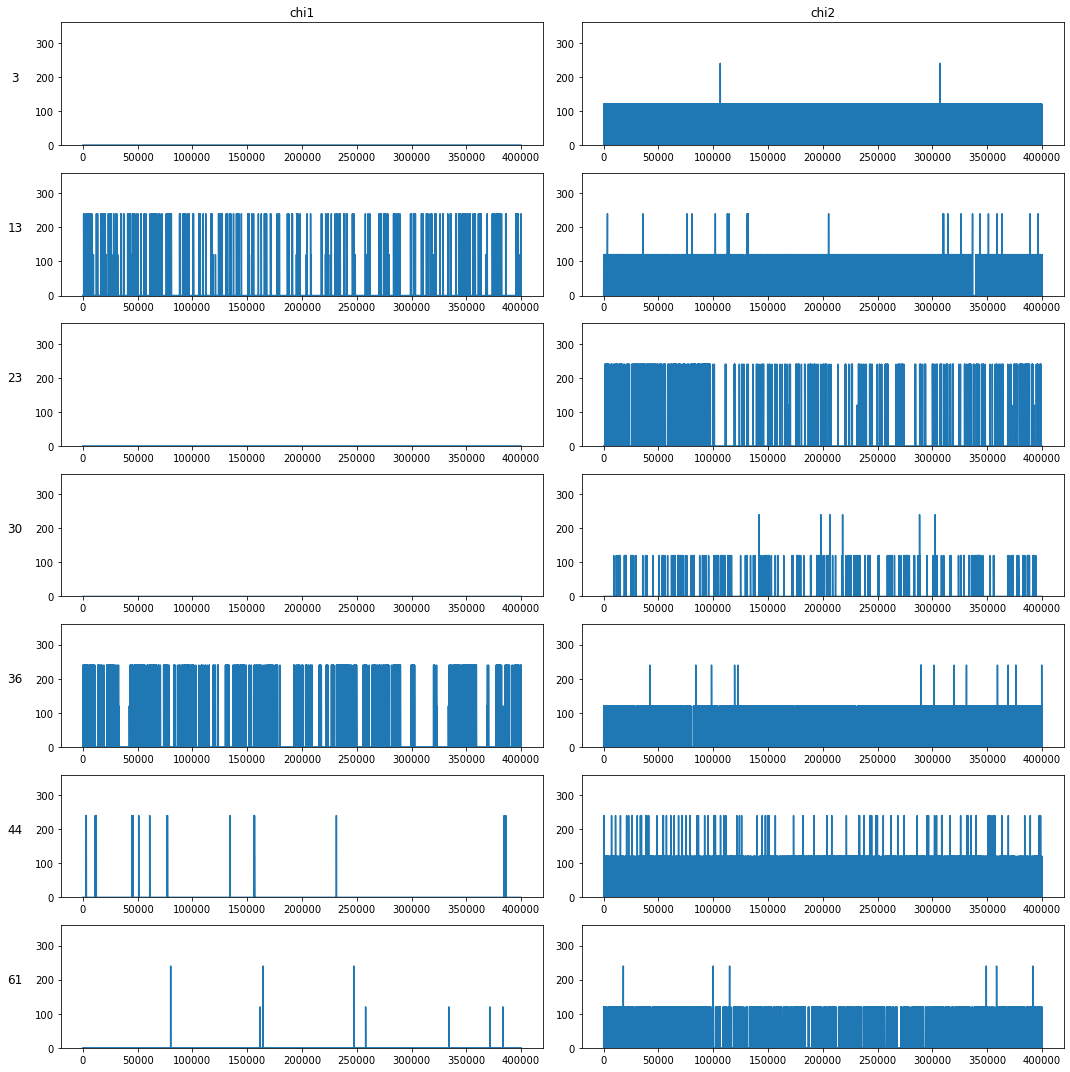

In [15]:
fig, axs = plt.subplots(len(isoleucines), 2, figsize = [15,15])
for i, ile in enumerate(isoleucines):
    axs[i,0].plot(chi1_diff[ile])
    axs[i,0].set_ylim([0, 360])
    axs[i,1].plot(chi2_diff[ile])
    axs[i,1].set_ylim([0, 360])
for ax, col in zip(axs[0], ["chi1", "chi2"]):
    ax.set_title(col)
for ax, row in zip(axs[:,0], isoleucines):
    ax.set_ylabel(row, rotation=0, size='large')
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20
fig.tight_layout()
plt.show()

In [16]:
print("amount of jumps in trajectory: " + str(len(J.results.angles)))
for ile in isoleucines:
    count1 = (chi1_diff[ile] != 0).sum()
    count2 = (chi2_diff[ile] != 0).sum()
    print(f"{ile} \t {count1} \t {count2}")

amount of jumps in trajectory: 400001
3 	 1 	 30330
13 	 365 	 39786
23 	 1 	 1428
30 	 1 	 402
36 	 1685 	 8375
44 	 77 	 30572
61 	 18 	 1537


Text(0.5, 1.0, 'Chi2')

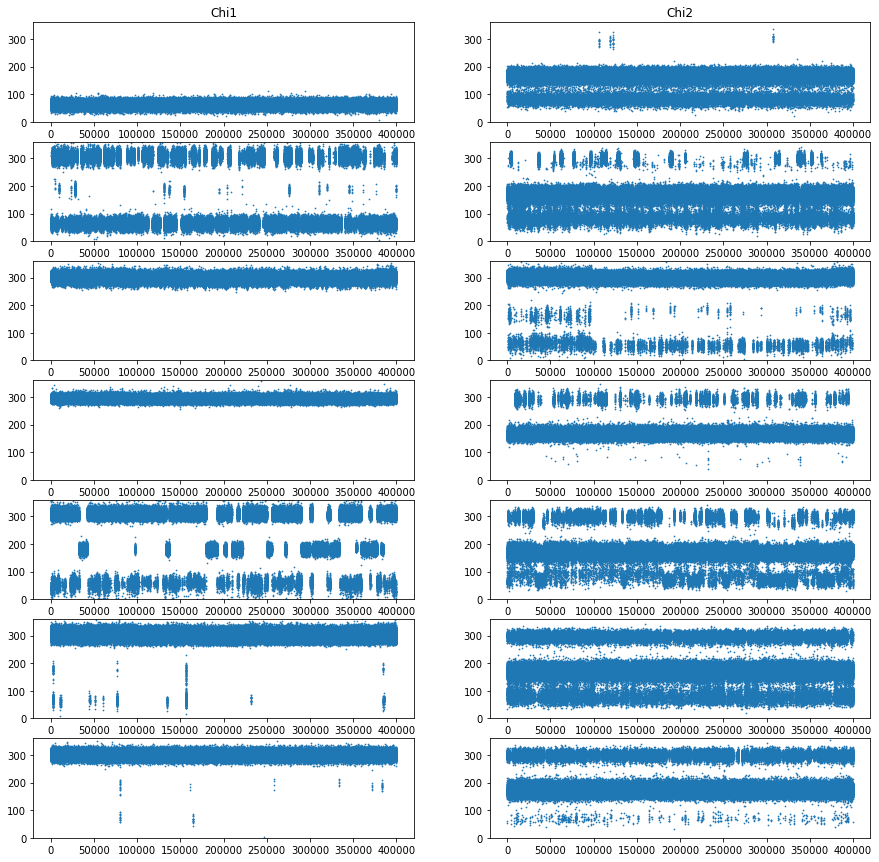

In [19]:
fig, axs = plt.subplots(len(isoleucines), 2, figsize = [15,15])
for i, ile in enumerate(isoleucines):
    axs[i,0].scatter(np.arange(len(J.results.angles)), J.results.angles[:, i, 0], s=0.5)
    axs[i,0].set_ylim([0, 360])
    axs[i,1].scatter(np.arange(len(J.results.angles)),J.results.angles[:, i, 1], s=0.5)
    axs[i,1].set_ylim([0, 360])
axs[0,0].set_title('Chi1')
axs[0,1].set_title('Chi2')